## Analysis of Singapore counterfeit drugs
- Author: Kenneth Leung (https://linkedin.com/in/kennethleungty)
- Date of analysis: 15 August 2020  
- Data Source: https://oscar.hsa.gov.sg/Publication/ahpdm/faces/AHPPublication.jspx?_afrLoop=100428428947200776&_afrWindowMode=0&_adf.ctrl-state=hz7d8w1f_58

## Step 1 - Data Curation

- Copy paste from HSA OSCAR site into Notepad++, then saved as text file
- Omitted Images in this analysis
- Import text file into Microsoft Excel using the Tab Delimited option, and manually added row headers in Excel sheet
- Save the sheet as xlsx file
___

## Step 2 - Data Exploration and Cleaning

In [83]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import jieba
import re
from os import path
from collections import Counter 

%matplotlib inline
sns.set_style('darkgrid')

In [104]:
matplotlib.rc('font', size=14)

In [2]:
font_path = 'C:\Windows\Fonts\simhei.ttf'

In [3]:
df_all = pd.read_excel(r"Cleaned Dataset 20200824.xlsx")

In [4]:
len(df_all)

245

In [5]:
df_all.sample(19)

,SN,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
35,36,Bull's Genital male sexual stimulant,Capsule,Yellow,Oval,No,,Sildenafil
208,209,JinMaoShiWang 1500mg Tablet (金毛狮王片),,Brown,Teardrop,Yes,SV,Sildenafil
65,66,SHEN QI DAN BAI NIAN CAO YAO '神奇丹 百年草药’,Capsule,Brown,Oblong,No,,
58,59,Surut Ayu Jamu Herbal Ramuan Alami,Capsule,Red ;White,Oblong,No,,Sibutramine
101,102,Li Long Brand Xi Yu Shen Bao 2800mg Tablet (力龙...,,Brown,Teardrop,Yes,力龙,Sildenafil
128,129,expressherbals No.1 Mens Supplement Worldwide ...,Capsule,White,Oblong,No,,Sildenafil
173,174,Li Zhi Yuan Brand Qiang Jing Wei Ge Wang Wu Bi...,,Blue,Diamond,Yes,800mg,Lignocaine ;Sildenafil ;Tadalafil ;Theophyllin...
45,46,Li Long Brand Ling Tou Lang 2800mg Capsule (力龙...,Capsule,Blue ;White,Oblong,Yes,力龙生物,Sildenafil
66,67,Ricalinu,Capsule,Black ;Yellow,Oblong,No,,Meloxicam ;Tramadol
169,170,Shen Wei Brand Tian Di Ying Xiong 2000mg Capsu...,Capsule,Pink,Oblong,No,,Sildenafil


Drop SN number (since this number is not unique for the items in the HSA OSCAR system)

In [6]:
df_all.drop(['SN'], axis=1, inplace = True)

In [7]:
df_all.head()

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
0,Li Long Brand Jin Gang Shen Dan 2800mg Capsule...,Capsule,Green,Oblong,Yes,力龙生物,Sildenafil
1,Jiu Chong Tian Capsule (九重天),Capsule,Beige ;Red,Oblong,No,,Sildenafil
2,Buda Jin Qiang Bu Dao 800 mg Tablet (金枪不倒),,Brown,Irregular,No,,Sildenafil
3,Kang Xi Da Di Long Yang Dan 1000mg Capsule (康熙...,Capsule,Green,Oblong,Yes,金聖力 and two creatures facing one another,Sildenafil
4,ZhengHao Brand King of Postponing Spray (延时王),Spray,,,No,,Lignocaine ;Sildenafil


In [8]:
dosage_form_empty = df_all[df_all['Dosage Form'] == ' ']

In [9]:
len(dosage_form_empty)

54

In [10]:
df_filled_dosage_form = df_all[~(df_all['Dosage Form'] == ' ')]

In [11]:
len(df_filled_dosage_form)

191

If drug name contains Tablet, then assign Dosage Form to be tablet

In [12]:
df_tabs = df_all[(df_all['Product Description'].str.contains('Tablet').any()) & (df_all['Dosage Form'] == ' ')]
#df_non_tabs = pd.concat([df_all, df_tabs, df_tabs]).drop_duplicates(keep=False)

In [13]:
len(df_tabs)

54

In [14]:
df_tabs.head()

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
2,Buda Jin Qiang Bu Dao 800 mg Tablet (金枪不倒),,Brown,Irregular,No,,Sildenafil
5,Lang Yi Hao 145mg Tablet (极品狼1号),,Blue,Diamond,Yes,DL,Metronidazole ;Sildenafil
8,Super Power Pills 1800 mg Tablet (力加力),,Red,Hexagon,Yes,SUPER,Sildenafil
12,Buda Jin Qiang Bu Dao 800 mg Tablet (金枪不倒),,Brown,Irregular,No,,Sildenafil
15,Lang Yi Hao 145mg Tablet (极品狼1号),,Blue,Diamond,Yes,DL,Metronidazole ;Sildenafil


In [15]:
df_tabs[['Dosage Form']] = 'Tablet'

In [16]:
df_tabs.sample(8)

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
173,Li Zhi Yuan Brand Qiang Jing Wei Ge Wang Wu Bi...,Tablet,Blue,Diamond,Yes,800mg,Lignocaine ;Sildenafil ;Tadalafil ;Theophyllin...
92,Strong Boy,Tablet,Brown,Round,Yes,USA on one side / PA NT HE R on the other side,Sildenafil
244,Black Ant King (黑蚁王),Tablet,Green,Oval,Yes,CPM,Sildenafil
24,Miraculous Evil Root 1200mg Tablet (神奇魔根),Tablet,Yellow,Teardrop,Yes,C120,Sildenafil
5,Lang Yi Hao 145mg Tablet (极品狼1号),Tablet,Blue,Diamond,Yes,DL,Metronidazole ;Sildenafil
61,Li Da Weight Loss Capsule,Tablet,Green,Oblong,No,,Sibutramine
96,Jin Sheng Li Brand America Brother 1000mg Tabl...,Tablet,Blue,Diamond,Yes,VAG,Sildenafil
29,Ju He Tang Brand Mei Guo Zhan Shen 1000mg Tabl...,Tablet,Black,Oblong,Yes,Drawing of a dragon,Sildenafil ;Vardenafil


In [17]:
# Recombine the split dataframes
df_updated = pd.concat([df_tabs, df_filled_dosage_form], ignore_index = True)

In [18]:
len(df_updated)

245

In [19]:
# Sort alphabetical order
df_updated.sort_values(by=['Product Description'], inplace = True)

In [20]:
df_updated.head(10)

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
179,18 Spring Gel (十八春催情缩阴精华素),Gel,Transparent,,No,,Sildenafil
103,24Hrs Burn,Capsule,Brown,Oblong,No,,Sibutramine
118,4X Lebih Dahsyat Obat Kuat & Tahan Lama Urat M...,Capsule,Red,Oblong,Yes,URAT MADU,Sildenafil
84,AMACE For Him 300mg/capsule,Capsule,Blue ;White,Oblong,No,,N-cyclopentyl Nortadalafil
188,Africa Black Ant 2500mg Capsule (非洲黑蚁王),Capsule,White,Oblong,Yes,金聖力,Imidazosagatriazinone ;Sibutramine ;Sildenafil...
112,Aidi Brand Wodibo Capsule (艾迪牌五便宝胶囊),Capsule,Blue,Oblong,No,,Sildenafil ;Tadalafil
41,Ali Baba,Tablet,Brown,,No,,Lignocaine
155,Aliba (阿里巴巴男士性功能专用),Capsule,Blue,Oblong,Yes,阿里巴巴,Sildenafil ;Tadalafil ;Vardenafil
149,Aloe Vera Waste Discharging & Beauty 250mg Cap...,Capsule,Green,Oblong,No,,Sibutramine
193,America Cowboy 500mg Capsule (美國牛仔胶囊),Capsule,Green,Oblong,No,,Sildenafil


In [21]:
# Replace all space values with NA value
df_final = df_updated.replace(r'^\s*$', np.nan, regex=True)

In [22]:
df_final.head(15)

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants
179,18 Spring Gel (十八春催情缩阴精华素),Gel,Transparent,NaN,No,NaN,Sildenafil
103,24Hrs Burn,Capsule,Brown,Oblong,No,NaN,Sibutramine
118,4X Lebih Dahsyat Obat Kuat & Tahan Lama Urat M...,Capsule,Red,Oblong,Yes,URAT MADU,Sildenafil
84,AMACE For Him 300mg/capsule,Capsule,Blue ;White,Oblong,No,NaN,N-cyclopentyl Nortadalafil
188,Africa Black Ant 2500mg Capsule (非洲黑蚁王),Capsule,White,Oblong,Yes,金聖力,Imidazosagatriazinone ;Sibutramine ;Sildenafil...
112,Aidi Brand Wodibo Capsule (艾迪牌五便宝胶囊),Capsule,Blue,Oblong,No,NaN,Sildenafil ;Tadalafil
41,Ali Baba,Tablet,Brown,NaN,No,NaN,Lignocaine
155,Aliba (阿里巴巴男士性功能专用),Capsule,Blue,Oblong,Yes,阿里巴巴,Sildenafil ;Tadalafil ;Vardenafil
149,Aloe Vera Waste Discharging & Beauty 250mg Cap...,Capsule,Green,Oblong,No,NaN,Sibutramine
193,America Cowboy 500mg Capsule (美國牛仔胶囊),Capsule,Green,Oblong,No,NaN,Sildenafil


Reviewing missing data

In [23]:
df_final.isna().sum()

Product Description                  0
Dosage Form                          0
Dosage Form Color                    9
Dosage Form Shape                   20
Dosage Form Marking                  0
Remarks for Dosage Form Marking    150
Adulterants                          1
dtype: int64

___
## Step 3 - Analysing Characteristics (Column-wise)

Given that there are many Chinese characters in these counterfeit drugs, the analysis should include the Chinese characters. https://amueller.github.io/word_cloud/auto_examples/wordcloud_cn.html

### 1) Product Description / Product Names

In [24]:
product_names = df_final['Product Description'].values

In [45]:
# Removing stopwords (Jiao nang means Capsule)
product_stopwords = ['Tablet','Capsule','Capsules','Tablets','Brand',"Capsule'",'500mg','2000mg', 'Jiao', 'Nang']

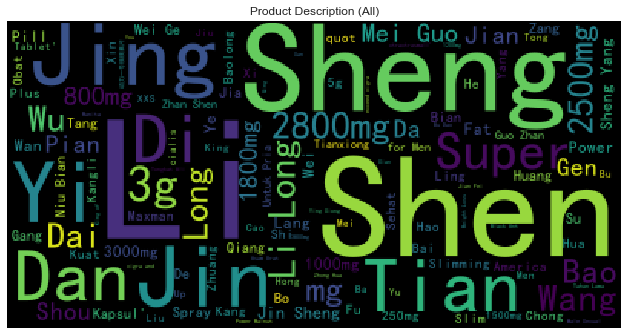

In [51]:
#wordcloud = WordCloud(font_path=font_path.generate(str(product_names)))
wordcloud = WordCloud(stopwords = product_stopwords, font_path = font_path).generate(str(product_names))

plt.figure(figsize=(11,11))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud.recolor(random_state=1))
plt.title('Product Description (All)')
plt.axis("off")
plt.savefig('Images/Product Description - Full Wordcloud.png')
plt.show()

#### Assessing products containing Chinese characters

In [27]:
df_has_chinese = df_final[df_final['Product Description'].str.contains(r'[\u4e00-\u9fff]+', regex = True)]

In [28]:
len(df_has_chinese)

180

In [32]:
df_has_chinese['Has Chinese Char'] = 1

Number of products without Chinese characters

In [29]:
df_no_chinese = df_final[~df_final.index.isin(df_has_chinese.index)]

In [30]:
len(df_no_chinese)

65

In [33]:
df_no_chinese['Has Chinese Char'] = 0

In [34]:
df_final = pd.concat([df_has_chinese, df_no_chinese], ignore_index = True)

In [35]:
df_final.head()

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants,Has Chinese Char
0,18 Spring Gel (十八春催情缩阴精华素),Gel,Transparent,NaN,No,NaN,Sildenafil,1
1,Africa Black Ant 2500mg Capsule (非洲黑蚁王),Capsule,White,Oblong,Yes,金聖力,Imidazosagatriazinone ;Sibutramine ;Sildenafil...,1
2,Aidi Brand Wodibo Capsule (艾迪牌五便宝胶囊),Capsule,Blue,Oblong,No,NaN,Sildenafil ;Tadalafil,1
3,Aliba (阿里巴巴男士性功能专用),Capsule,Blue,Oblong,Yes,阿里巴巴,Sildenafil ;Tadalafil ;Vardenafil,1
4,Aloe Vera Waste Discharging & Beauty 250mg Cap...,Capsule,Green,Oblong,No,NaN,Sibutramine,1


In [36]:
len(df_final)

245

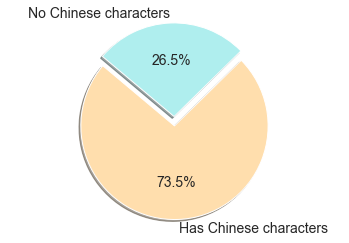

In [105]:
# Data to plot
labels = 'Has Chinese characters', 'No Chinese characters'

has_chinese = len(df_final[df_final['Has Chinese Char'] == 1])
no_chinese = len(df_final[df_final['Has Chinese Char'] == 0])

sizes = [has_chinese, no_chinese]
colors = ['navajowhite', 'paleturquoise']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.savefig('Images/Pie Chart - Chinese Characters')
plt.show()

#### Obtain all chinese characters for Chinese wordcloud
Reference: https://stackoverflow.com/questions/2718196/find-all-chinese-text-in-a-string-using-python-and-regex

In [ ]:
chinese_product_char_list = []

for product in product_names:
    for n in re.findall(r'[\u4e00-\u9fff]+', product):
        chinese_product_char_list.append(n)

In [ ]:
# Combine all the chinese characters into single string
chinese_char = ''.join(map(str, chinese_product_char_list))

In [ ]:
chinese_text = ' '.join(jieba.cut(chinese_char))
chinese_text

In [ ]:
chinese_stopwords = ['胶囊'] # Remove Capsule chinese word from wordcloud

wc_chinese = WordCloud(font_path=font_path, background_color="white", max_words=100, max_font_size=100, 
                       random_state=42, width=1000, height=860, margin=2, stopwords = chinese_stopwords)

wc_chinese.generate(chinese_text)

plt.figure(figsize=(11,11))

# Display the generated image the matplotlib way:
plt.imshow(wc_chinese.recolor(random_state=42))
plt.title('Product Description (Chinese)')
plt.axis("off")
plt.savefig('Images/Product Description - Chi Wordcloud.png')
plt.show()

Reviewing non Chinese-character containing products

In [38]:
non_chinese_product_names = df_no_chinese['Product Description'].values

In [52]:
non_chinese_stopwords = ['Tablet','Capsule','Brand',"Capsule'",'500mg','2000mg', 'Jiao', 'Nang',
                        "Kapsul'","Tablet'",'Dan','for', 'Obat']

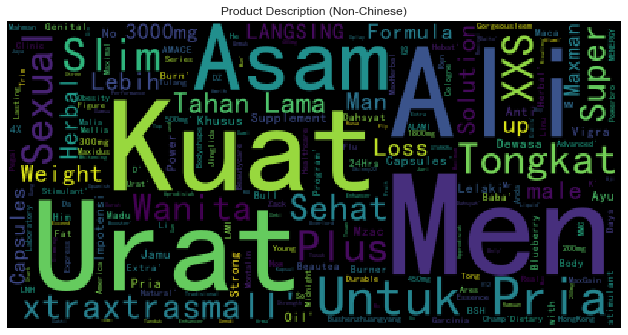

In [53]:
#wordcloud = WordCloud(font_path=font_path.generate(str(product_names)))
wordcloud_non_chinese = WordCloud(stopwords = non_chinese_stopwords, font_path = font_path).generate(str(non_chinese_product_names))

plt.figure(figsize=(11,11))

# Display the generated image the matplotlib way:
plt.imshow(wordcloud_non_chinese.recolor(random_state=1))
plt.title('Product Description (Non-Chinese)')
plt.axis("off")
plt.savefig('Images/Product Description - Non-Chinese Wordcloud.png')
plt.show()

### 2) Dosage Form

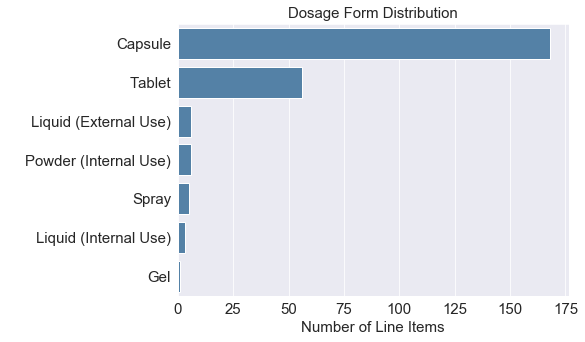

In [73]:
plt.figure(figsize=(7,5))

plot1 = sns.countplot(y='Dosage Form',data=df_final, color='steelblue', orient='h', order=df_final['Dosage Form'].value_counts().index)
plt.title('Dosage Form Distribution', fontsize=15);
plot1.tick_params(labelsize=15)
plot1.set_xlabel("Number of Line Items",fontsize=15)
plot1.set_ylabel(" ",fontsize=15)
plt.savefig('Images/Dosage Form.png',bbox_inches='tight')
plt.show()

### 3) Dosage Form Colour

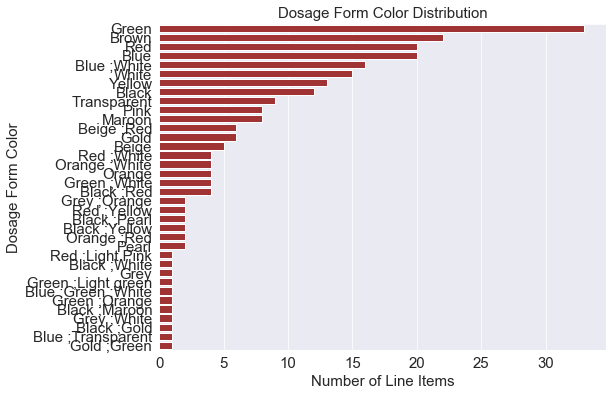

In [55]:
plt.figure(figsize=(8,6))

plot1 = sns.countplot(y='Dosage Form Color',data=df_final, color='firebrick', orient='h', order=df_final['Dosage Form Color'].value_counts().index)
plt.title('Dosage Form Color Distribution', fontsize=15);
plot1.tick_params(labelsize=15)
plot1.set_xlabel("Number of Line Items",fontsize=15)
plot1.set_ylabel("Dosage Form Color",fontsize=15)
plt.show()

Need to split the colour strings to obtain the individual colors

In [56]:
dosage_form_colors_list = df_final['Dosage Form Color'].values

In [57]:
dosage_form_colors_list

array(['Transparent', 'White', 'Blue', 'Blue', 'Green', 'Green',
       'Red ;White', 'Orange', 'Gold ;Green', 'Black', 'Maroon', 'Red',
       'Black ;Red', 'Maroon', 'Green', 'Yellow', 'Green', 'Pearl',
       'Green', 'Red', 'Green', 'Brown', 'Brown', 'Brown', 'Green',
       'Green', 'Blue ;White', 'Black', 'Black', 'Brown', 'Maroon',
       'Black ;Red', 'Grey ;Orange', 'Brown', 'Blue ;Transparent',
       'White', 'White', 'Green', 'Blue', nan, 'Yellow', 'Green', 'Green',
       'Blue', 'Red', 'Red', nan, 'Red', 'Red', 'Red', 'Red ;White',
       'Blue ;White', 'Blue', 'Green', 'Green', 'Green', 'Black', 'Blue',
       'Red', 'Brown', 'Beige ;Red', 'Beige ;Red', 'Black', 'Green',
       'Grey ;Orange', 'Green', 'Green', 'Black', 'Black ;Gold',
       'Black ;Pearl', 'Black ;Pearl', 'Gold', 'Green', 'Blue', 'Blue',
       'Green', 'Gold', 'Gold', 'Black', 'Beige', 'Green', 'Green',
       'Blue ;White', 'Green', 'Beige ;Red', 'Blue ;White', 'Blue ;White',
       'Brown', 'Red ;Whi

In [58]:
# Combine all the colors into single string
dosage_form_colors = ','.join(map(str, dosage_form_colors_list))

In [59]:
dosage_form_colors

'Transparent,White,Blue,Blue,Green,Green,Red ;White,Orange,Gold ;Green,Black,Maroon,Red,Black ;Red,Maroon,Green,Yellow,Green,Pearl,Green,Red,Green,Brown,Brown,Brown,Green,Green,Blue ;White,Black,Black,Brown,Maroon,Black ;Red,Grey ;Orange,Brown,Blue ;Transparent,White,White,Green,Blue,nan,Yellow,Green,Green,Blue,Red,Red,nan,Red,Red,Red,Red ;White,Blue ;White,Blue,Green,Green,Green,Black,Blue,Red,Brown,Beige ;Red,Beige ;Red,Black,Green,Grey ;Orange,Green,Green,Black,Black ;Gold,Black ;Pearl,Black ;Pearl,Gold,Green,Blue,Blue,Green,Gold,Gold,Black,Beige,Green,Green,Blue ;White,Green,Beige ;Red,Blue ;White,Blue ;White,Brown,Red ;White,Blue,Pearl,Blue ;White,Blue ;White,Beige ;Red,Green,Red,Blue ;White,Brown,Red,Transparent,Yellow,Beige,Transparent,White,Blue,Red,Green,Transparent,Blue,Green,Blue,Pink,Blue ;White,Beige,Brown,Transparent,Green ;White,Pink,Brown,Transparent,Blue ;White,White,Gold,Pink,Orange,Black,Black,Black,Gold,Gold,Yellow,Yellow,Maroon,Blue,Blue,Green ;White,Maroon,Orange,

In [60]:
dosage_form_colors_updated = dosage_form_colors.replace(' ;', ',')

In [61]:
dosage_form_colors_updated

'Transparent,White,Blue,Blue,Green,Green,Red,White,Orange,Gold,Green,Black,Maroon,Red,Black,Red,Maroon,Green,Yellow,Green,Pearl,Green,Red,Green,Brown,Brown,Brown,Green,Green,Blue,White,Black,Black,Brown,Maroon,Black,Red,Grey,Orange,Brown,Blue,Transparent,White,White,Green,Blue,nan,Yellow,Green,Green,Blue,Red,Red,nan,Red,Red,Red,Red,White,Blue,White,Blue,Green,Green,Green,Black,Blue,Red,Brown,Beige,Red,Beige,Red,Black,Green,Grey,Orange,Green,Green,Black,Black,Gold,Black,Pearl,Black,Pearl,Gold,Green,Blue,Blue,Green,Gold,Gold,Black,Beige,Green,Green,Blue,White,Green,Beige,Red,Blue,White,Blue,White,Brown,Red,White,Blue,Pearl,Blue,White,Blue,White,Beige,Red,Green,Red,Blue,White,Brown,Red,Transparent,Yellow,Beige,Transparent,White,Blue,Red,Green,Transparent,Blue,Green,Blue,Pink,Blue,White,Beige,Brown,Transparent,Green,White,Pink,Brown,Transparent,Blue,White,White,Gold,Pink,Orange,Black,Black,Black,Gold,Gold,Yellow,Yellow,Maroon,Blue,Blue,Green,White,Maroon,Orange,Blue,Green,Red,Red,Green,Whi

In [62]:
dosage_form_colors_final = dosage_form_colors_updated.split(",")

In [63]:
# Sort the list
dosage_form_colors_final = sorted(dosage_form_colors_final, key = dosage_form_colors_final.count, 
                                reverse = True) 

In [64]:
dosage_form_colors_final

['White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'White',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 '

In [65]:
type(dosage_form_colors_final)

list

In [66]:
dosage_form_colors_final_table = Counter(dosage_form_colors_final)

In [67]:
dosage_form_colors_final_df = pd.DataFrame.from_dict(dosage_form_colors_final_table, orient='index').reset_index()
dosage_form_colors_final_df.columns = ['Dosage Form Color', 'Frequency']

In [68]:
dosage_form_colors_final_df.head()

,Dosage Form Color,Frequency
0,White,46
1,Green,41
2,Red,39
3,Blue,38
4,Black,23


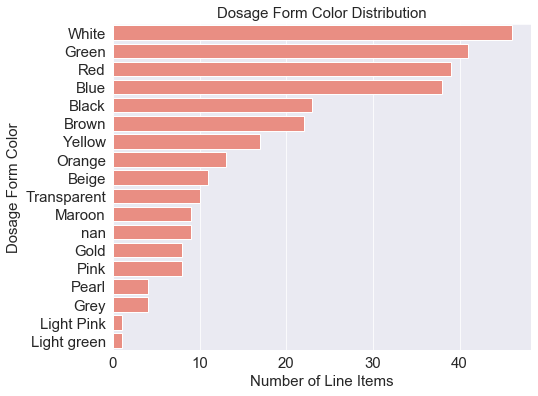

In [72]:
plt.figure(figsize=(7.5,6))

plot1 = sns.barplot(x="Frequency", y="Dosage Form Color", data=dosage_form_colors_final_df, 
                    orient = 'h', color = 'salmon')
plt.title('Dosage Form Color Distribution', fontsize=15);
plot1.tick_params(labelsize=15)
plot1.set_xlabel("Number of Line Items",fontsize=15)
plot1.set_ylabel("Dosage Form Color",fontsize=15)
plt.savefig('Images/Dosage Form Color.png',bbox_inches='tight')
plt.show()

### 3) Dosage Form Shape

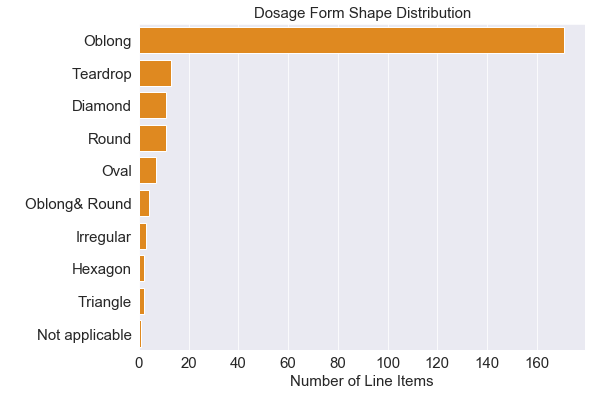

In [75]:
plt.figure(figsize=(8,6))

plot3 = sns.countplot(y='Dosage Form Shape',data=df_final, color='darkorange', orient='h', order=df_final['Dosage Form Shape'].value_counts().index)
plt.title('Dosage Form Shape Distribution', fontsize=15);
plot3.tick_params(labelsize=15)
plot3.set_xlabel("Number of Line Items",fontsize=15)
#plot3.set_ylabel("Dosage Form Shape",fontsize=15)
plot3.set_ylabel(" ",fontsize=15)
plt.savefig('Images/Dosage Form Shape.png',bbox_inches='tight')
plt.show()

Most common form/colour/shape

In [76]:
dosage_form_full = df_final[['Dosage Form', 'Dosage Form Color', 'Dosage Form Shape']]

In [77]:
dosage_form_full = dosage_form_full.assign(full_form = dosage_form_full['Dosage Form'].astype(str) + ', ' + \
  dosage_form_full['Dosage Form Color'].astype(str) + ', ' + dosage_form_full['Dosage Form Shape'].astype(str))

In [78]:
dosage_form_full_final = dosage_form_full['full_form']
dosage_form_all = pd.DataFrame(dosage_form_full_final.value_counts())

In [79]:
dosage_form_all.columns = ['Frequency']

In [80]:
dosage_form_all.head(10)

,Frequency
"Capsule, Green, Oblong",29
"Capsule, Red, Oblong",17
"Capsule, Blue ;White, Oblong",16
"Capsule, White, Oblong",12
"Tablet, Blue, Diamond",8
"Capsule, Pink, Oblong",7
"Capsule, Maroon, Oblong",7
"Capsule, Gold, Oblong",6
"Capsule, Blue, Oblong",6
"Tablet, Yellow, Teardrop",6


### 4) Dosage Form Marking

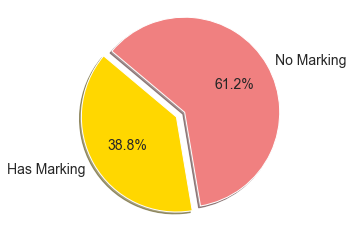

In [106]:
# Data to plot
labels = 'Has Marking', 'No Marking'

has_marking = len(df_final[df_final['Dosage Form Marking'] == 'Yes'])
no_marking = len(df_final[df_final['Dosage Form Marking'] == 'No'])

sizes = [has_marking, no_marking]
colors = ['gold', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.savefig('Images/Pie Chart - Dosage Form Marking.png')
plt.show()

### 5) Dosage Form Markings
- Not analyzing due to plenty of missing data, but unlikely to get much interesting insights

### 6) Adulterants

In [99]:
adulterants_list = df_final['Adulterants'].values
adulterants_list

array(['Sildenafil',
       'Imidazosagatriazinone ;Sibutramine ;Sildenafil ;Tadalafil',
       'Sildenafil ;Tadalafil', 'Sildenafil ;Tadalafil ;Vardenafil',
       'Sibutramine', 'Sildenafil', 'Sibutramine ;Sildenafil',
       'Sibutramine', 'Phenolphthalein ;Sibutramine', 'Sildenafil',
       'Phenolphthalein ;Sibutramine',
       'Chlorpheniramine ;Frusemide ;Piroxicam', 'Sildenafil',
       'Sildenafil', 'Sildenafil', 'Sildenafil',
       'Phenolphthalein ;Sibutramine', 'Sildenafil ;Tadalafil',
       'Sildenafil', 'Sildenafil ;Tadalafil',
       'Phenolphthalein ;Sibutramine', 'Sildenafil', 'Sildenafil',
       'Sildenafil',
       'Chlorpheniramine ;Frusemide ;Mephentermine ;Piroxicam',
       'Sibutramine ;Sildenafil', 'Sildenafil', 'Sildenafil ;Tadalafil',
       'Sildenafil', 'Lignocaine', 'Sildenafil', 'Sildenafil ;Tadalafil',
       'Sildenafil', 'Sildenafil', 'Sildenafil', 'Lignocaine',
       'Sildenafil', 'Phenolphthalein ;Sibutramine', 'Sildenafil',
       'Lignocaine', 

In [86]:
# Combine all adulterants into single string
adulterants = ','.join(map(str, adulterants_list))

In [87]:
adulterants_updated = adulterants.replace(' ;', ',')

In [88]:
# Sort the list
adulterants_final = adulterants_updated.split(",")
adulterants_final = sorted(adulterants_final, key = adulterants_final.count, 
                                reverse = True) 

In [89]:
adulterants_table = Counter(adulterants_final)

In [90]:
adulterants_table

Counter({'Sildenafil': 158,
         'Sibutramine': 68,
         'Tadalafil': 30,
         'Phenolphthalein': 23,
         'Lignocaine': 21,
         'Dexamethasone': 7,
         'Piroxicam': 6,
         'Diclofenac': 6,
         'Vardenafil': 5,
         'Chlorpheniramine': 4,
         'Frusemide': 4,
         'Glibenclamide': 4,
         'Paracetamol': 4,
         'Metronidazole': 3,
         'Imidazosagatriazinone': 2,
         'Indomethacin': 2,
         'Acetic Acid': 2,
         'Acetildenafil': 2,
         'Ibuprofen': 2,
         'Caffeine': 2,
         'N-cyclopentyl Nortadalafil': 2,
         'Mephentermine': 1,
         'Prednisolone': 1,
         'Procaine': 1,
         'Pheniramine': 1,
         'Norethisterone': 1,
         'Naproxen': 1,
         'Strychnine': 1,
         'Theophylline': 1,
         'Verapamil': 1,
         'Carbodenafil': 1,
         'Chloropretadalafil': 1,
         'Hydroxythiohomosildenafil': 1,
         'nan': 1,
         'Metformin': 1,
         'P

In [91]:
adulterants_df = pd.DataFrame.from_dict(adulterants_table, orient='index').reset_index()

In [92]:
adulterants_df.columns = ['Adulterant', 'Frequency']

In [93]:
# Drop rows which are NA
adulterants_df = adulterants_df.drop(adulterants_df[adulterants_df['Adulterant'] == 'nan'].index)

In [94]:
adulterants_df.head(10)

,Adulterant,Frequency
0,Sildenafil,158
1,Sibutramine,68
2,Tadalafil,30
3,Phenolphthalein,23
4,Lignocaine,21
5,Dexamethasone,7
6,Piroxicam,6
7,Diclofenac,6
8,Vardenafil,5
9,Chlorpheniramine,4


In [95]:
# Products containing lignocaine
df_final_no_na_adul = df_final[df_final['Adulterants'].notnull()]
lignocaine_products = df_final_no_na_adul[df_final_no_na_adul['Adulterants'].str.contains('Lignocaine')]

In [96]:
lignocaine_products

,Product Description,Dosage Form,Dosage Form Color,Dosage Form Shape,Dosage Form Marking,Remarks for Dosage Form Marking,Adulterants,Has Chinese Char
29,De Guo Jin Gang Pen (德国金刚喷),Liquid (External Use),Brown,NaN,No,NaN,Lignocaine,1
35,French Silver Fox 2800mg Powder (法国银狐),Powder (Internal Use),White,NaN,No,NaN,Lignocaine,1
39,High-Powered Spray (威の猛男用延时喷剂),Spray,NaN,NaN,No,NaN,Lignocaine,1
64,Kang Li Brand Zhong Hua Niu Bian 1500mg Capsul...,Capsule,Grey ;Orange,Oblong,No,NaN,Glibenclamide ;Lignocaine ;Norethisterone ;Sib...,1
68,Kangli Brand JinBa Men 2500mg (康力牌劲霸男人),Capsule,Black ;Gold,Oblong& Round,Yes,KANGLI 速效壮阳,Lignocaine ;Naproxen ;Sildenafil,1
84,Li Long Brand Mei Guo Zhan Shen 2500mg Capsule...,Capsule,Beige ;Red,Oblong,No,NaN,Lignocaine ;Sildenafil ;Tadalafil,1
89,Li Zhi Yuan Brand Qiang Jing Wei Ge Wang Wu Bi...,Tablet,Blue,Diamond,Yes,800mg,Lignocaine ;Sildenafil ;Tadalafil ;Theophyllin...,1
97,Mei Guo Zhan Shen Wai Yong Shen You (美国战神外用神油),Liquid (External Use),Brown,NaN,No,NaN,Lignocaine ;Verapamil,1
99,Migino Capsule (美人露),Capsule,Transparent,Oblong,No,NaN,Lignocaine,1
107,Posh For Men Only Capsule (寳士情人秘膏),Liquid (External Use),Transparent,Oblong,No,NaN,Lignocaine,1


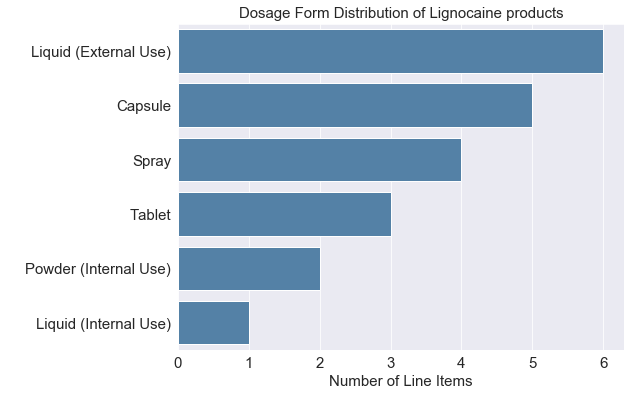

In [109]:
plt.figure(figsize=(8,6))

plot7 = sns.countplot(y='Dosage Form',data=lignocaine_products, color='steelblue', orient='h', order=lignocaine_products['Dosage Form'].value_counts().index)
plt.title('Dosage Form Distribution of Lignocaine products', fontsize=15);
plot7.tick_params(labelsize=15)
plot7.set_xlabel("Number of Line Items",fontsize=15)
#plot3.set_ylabel("Dosage Form Shape",fontsize=15)
plot7.set_ylabel(" ",fontsize=15)
plt.savefig('Images/Lignocaine Dosage Form.png',bbox_inches='tight')
plt.show()